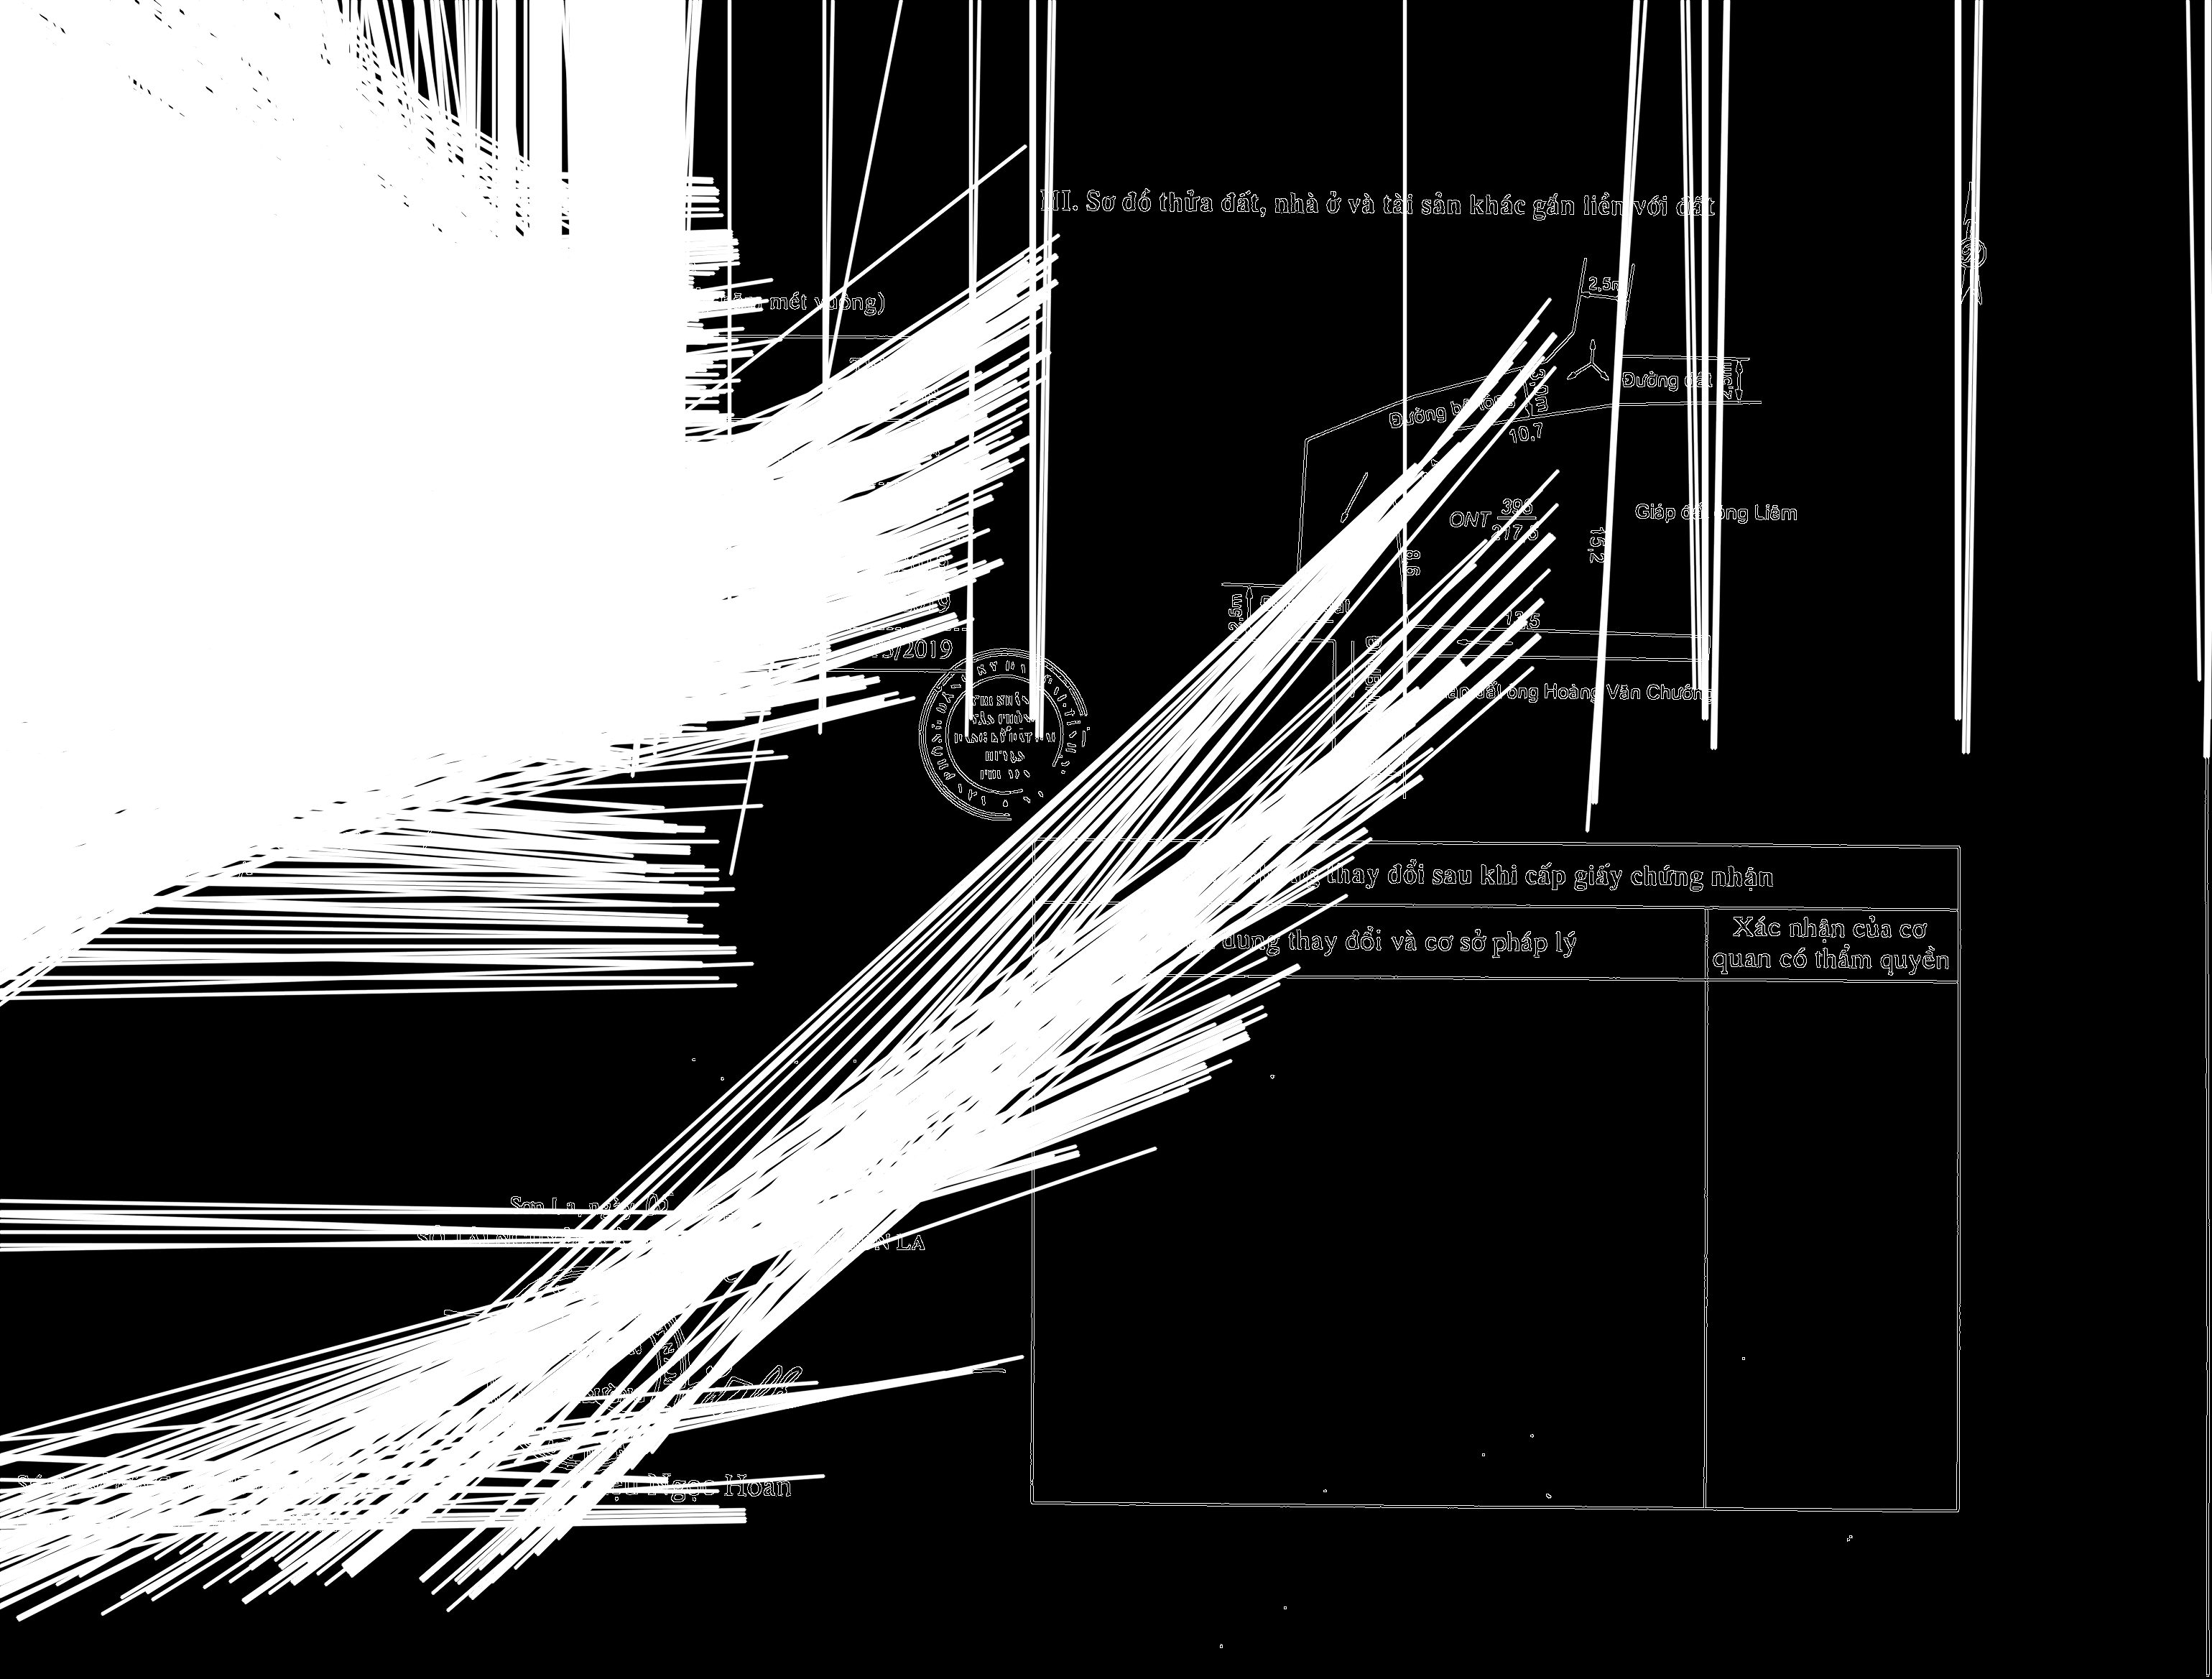

In [1]:
from PIL import Image
import cv2
from IPython.display import display
import numpy as np
from matplotlib import pyplot as plt
from os import walk
import math

def canny_edge_detection(img, blur_ksize=5, threshold1=100, threshold2=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray,(blur_ksize,blur_ksize),0)
    img_canny = cv2.Canny(img_gaussian,threshold1,threshold2)
    return img_canny

def corr(img, template):
    w, h = template.shape[::-1]
    img = cv2.resize(img, (w, h))
    # Apply template Matching
    res = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    return min_val
#     print(min_val, max_val, min_loc, max_loc)
    
#     min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
#     top_left = max_loc
#     bottom_right = (top_left[0] + w, top_left[1] + h)
#     cv2.rectangle(img,top_left, bottom_right, 255, 2)
#     plt.subplot(121),plt.imshow(res,cmap = 'gray')
#     plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
#     plt.subplot(122),plt.imshow(img,cmap = 'gray')
#     plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
#     plt.suptitle('cv2.TM_CCORR_NORMED')
#     plt.show()

def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

def findContours(img):
    thresh = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
    #thresh = cv2.threshold(gray, 115, 255, cv2.THRESH_BINARY_INV)[1]

    # Create a kernel (i.e. a small matrix)
    kernel = np.ones((5,5),np.uint8)

    # Use the kernel to perform morphological opening
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Find the contours
    cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.RETR_EXTERNAL)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    for c in cnts:
        cv2.drawContours(img,[c], 0, (36,255,12), 2)
    return img

def removeSpace(img):
    original = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (25,25), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Perform morph operations, first open to remove noise, then close to combine
    noise_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, noise_kernel, iterations=2)
    close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, close_kernel, iterations=3)

    # Find enclosing boundingbox and crop ROI
    coords = cv2.findNonZero(close)
    x,y,w,h = cv2.boundingRect(coords)
    cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)
    crop = original[y:y+h, x:x+w]
    return crop

def listFile(path):
    return next(walk(path), (None, None, []))[2]  # [] if no file

def polar2cartesian(rho: float, theta_rad: float, rotate90: bool = False):
    """
    Converts line equation from polar to cartesian coordinates

    Args:
        rho: input line rho
        theta_rad: input line theta
        rotate90: output line perpendicular to the input line

    Returns:
        m: slope of the line
           For horizontal line: m = 0
           For vertical line: m = np.nan
        b: intercept when x=0
    """
    x = np.cos(theta_rad) * rho
    y = np.sin(theta_rad) * rho
    m = np.nan
    if not np.isclose(x, 0.0):
        m = y / x
    if rotate90:
        if m is np.nan:
            m = 0.0
        elif np.isclose(m, 0.0):
            m = np.nan
        else:
            m = -1.0 / m
    b = 0.0
    if m is not np.nan:
        b = y - m * x
    return m, b

def line_end_points_on_image(rho: float, theta: float, image_shape: tuple):
    """
    Returns end points of the line on the end of the image
    Args:
        rho: input line rho
        theta: input line theta
        image_shape: shape of the image

    Returns:
        list: [(x1, y1), (x2, y2)]
    """
    m, b = polar2cartesian(rho, theta, True)
    end_pts = []
    if not np.isclose(m, 0.0):
        x = int(0)
        y = int(solve4y(x, m, b))
        if point_on_image(x, y, image_shape):
            end_pts.append((x, y))
            x = int(image_shape[1] - 1)
            y = int(solve4y(x, m, b))
            if point_on_image(x, y, image_shape):
                end_pts.append((x, y))
    if m is not np.nan:
        y = int(0)
        x = int(solve4x(y, m, b))
        if point_on_image(x, y, image_shape):
            end_pts.append((x, y))
            y = int(image_shape[0] - 1)
            x = int(solve4x(y, m, b))
            if point_on_image(x, y, image_shape):
                end_pts.append((x, y))
    return end_pts

def solve4x(y: float, m: float, b: float):
    """
    From y = m * x + b
         x = (y - b) / m
    """
    if np.isclose(m, 0.0):
        return 0.0
    if m is np.nan:
        return b
    return (y - b) / m

def solve4y(x: float, m: float, b: float):
    """
    y = m * x + b
    """
    if m is np.nan:
        return b
    return m * x + b

def point_on_image(x: int, y: int, image_shape: tuple):
    """
    Returns true is x and y are on the image
    """
    return 0 <= y < image_shape[0] and 0 <= x < image_shape[1]

def intersection(m1: float, b1: float, m2: float, b2: float):
    # Consider y to be equal and solve for x
    # Solve:
    #   m1 * x + b1 = m2 * x + b2
    x = (b2 - b1) / (m1 - m2)
    # Use the value of x to calculate y
    y = m1 * x + b1

    return int(round(x)), int(round(y))

def hough_lines_end_points(lines: np.array, image_shape: tuple):
    """
    Returns end points of the lines on the edge of the image
    """
    if len(lines.shape) == 3 and \
            lines.shape[1] == 1 and lines.shape[2] == 2:
        lines = np.squeeze(lines)
    end_pts = []
    for line in lines:
        rho, theta = line
        end_pts.append(
            line_end_points_on_image(rho, theta, image_shape))
    return end_pts

def hough_lines_intersection(lines: np.array, image_shape: tuple):
    """
    Returns the intersection points that lie on the image
    for all combinations of the lines
    """
    if len(lines.shape) == 3 and \
            lines.shape[1] == 1 and lines.shape[2] == 2:
        lines = np.squeeze(lines)
    lines_count = len(lines)
    intersect_pts = []
    for i in range(lines_count - 1):
        for j in range(i + 1, lines_count):
            m1, b1 = polar2cartesian(lines[i][0], lines[i][1], True)
            m2, b2 = polar2cartesian(lines[j][0], lines[j][1], True)
            x, y = intersection(m1, b1, m2, b2)
            if point_on_image(x, y, image_shape):
                intersect_pts.append([x, y])
    return np.array(intersect_pts, dtype=int)

blurKSize = (150, 150)
results = []

# for path in listFile('./loai_1'):
#     img = cv2.imread('loai_1/' + path)
#     img = removeSpace(img)
#     img = canny_edge_detection(img, 5, 0, 200)
#     img = cv2.blur(img, blurKSize)
#     # img = findContours(img)
#     # img = apply_brightness_contrast(img, 12, 24)
#     # display(Image.fromarray(img))
#     # contours = cv2.findContours(img, cv2.RETR_LIST, cv2.RETR_EXTERNAL)

#     template = cv2.imread('loai_1/CE428771-1.png')
#     template = removeSpace(template)
#     template = canny_edge_detection(template, 5, 0, 200)
#     template = cv2.blur(template, blurKSize)

#     results.append([corr(img, template), 0])

# for idx, path in enumerate(listFile('./loai_2')):
#     img = cv2.imread('loai_2/' + path)
#     img = removeSpace(img)
#     img = canny_edge_detection(img, 5, 0, 200)
#     img = cv2.blur(img, blurKSize)
#     # img = findContours(img)
#     # img = apply_brightness_contrast(img, 12, 24)
#     # display(Image.fromarray(img))
#     # contours = cv2.findContours(img, cv2.RETR_LIST, cv2.RETR_EXTERNAL)

#     template = cv2.imread('loai_1/CE428771-1.png')
#     template = removeSpace(template)
#     template = canny_edge_detection(template, 5, 0, 200)
#     template = cv2.blur(template, blurKSize)

#     results[idx][1] = corr(img, template)

# print("Template loại 1")
# print("Kết quả:")
# for res in results:
#     print("Loại 1: ", res[0], ", loại 2: ", res[1])

template = cv2.imread('loai_2/CE428748-3.png')
template = removeSpace(template)
template = canny_edge_detection(template, 5, 0, 200)

lines = cv2.HoughLines(template, 2, np.pi / 180, 300)
# Draw the lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(template, pt1, pt2, (255,0,255), 3, cv2.LINE_AA)
display(Image.fromarray(template))



# template = cv2.blur(template, blurKSize)
# template = findContours(template)
# display(Image.fromarray(template))
